In [1]:
#imports
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree
import numpy as np
import pickle
from backtesting import Backtest, Strategy

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
#load data from a csv file (this file is cleaned)
#df = pd.read_csv('DataNExcels/df_microdt_linkedin.csv', index_col='Date')
df = pd.read_csv('DataNExcels/df_microdt_linkedin.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume,percentual_change,change_direction
0,2016-12-08 00:00:00-05:00,61.299999,61.580002,60.840000,61.009998,55.705238,21220800,1.549141,UP
1,2016-12-09 00:00:00-05:00,61.180000,61.990002,61.130001,61.970001,56.581764,27349400,0.321694,UP
2,2016-12-12 00:00:00-05:00,61.820000,62.299999,61.720001,62.169998,56.764374,20198100,1.286125,UP
3,2016-12-13 00:00:00-05:00,62.500000,63.419998,62.240002,62.980000,57.503960,35718900,-0.478620,DOWN
4,2016-12-14 00:00:00-05:00,63.000000,63.450001,62.529999,62.680000,57.230038,30352700,-0.159793,DOWN
...,...,...,...,...,...,...,...,...,...
1784,2024-01-12 00:00:00-05:00,385.489990,388.679993,384.649994,388.470001,388.470001,21645700,0.461216,UP
1785,2024-01-16 00:00:00-05:00,393.660004,394.029999,387.619995,390.269989,390.269989,27202300,-0.205404,DOWN
1786,2024-01-17 00:00:00-05:00,387.980011,390.109985,384.809998,389.470001,389.470001,22234100,1.117118,UP
1787,2024-01-18 00:00:00-05:00,391.720001,393.989990,390.119995,393.869995,393.869995,23392100,1.204008,UP


In [3]:
#separete data into target and explanatory
target = df['percentual_change']
explanatory = df[['Open', 'High', 'Low', 'Close', 'Volume']]

In [4]:
#create model
model_dt = DecisionTreeRegressor(max_depth=15)

In [5]:
model_dt.fit(X=explanatory, y=target)

DecisionTreeRegressor(max_depth=15)

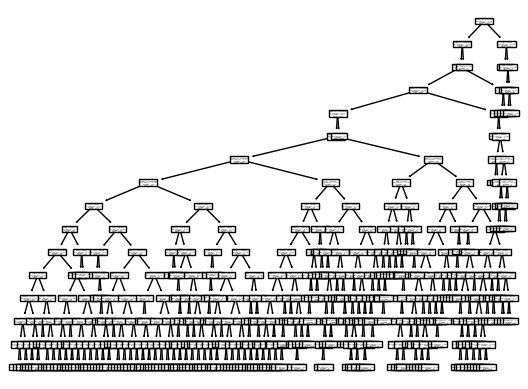

In [6]:
#plot our tree
plot_tree(decision_tree=model_dt, feature_names=model_dt.feature_names_in_);

In [7]:
#predict
y_pred = model_dt.predict(X=explanatory)
y_pred

array([ 0.11390714,  0.25417862,  0.11390714, ...,  0.60354793,
        0.47202923, -0.54475388])

In [8]:
df_predictions = df[['percentual_change']].copy()
df_predictions['prediction'] = y_pred
df_predictions

,percentual_change,prediction
0,1.549141,0.113907
1,0.321694,0.254179
2,1.286125,0.113907
3,-0.478620,0.435360
4,-0.159793,0.188104
...,...,...
1784,0.461216,0.404175
1785,-0.205404,0.098376
1786,1.117118,0.603548
1787,1.204008,0.472029


In [9]:
score = model_dt.score(X=explanatory, y=target)
print(f'Model precision is {score*100:.2f}%')

Model precision is 53.91%


In [10]:
#Calculate the error
df_predictions['error'] = df_predictions['prediction'] - df_predictions['percentual_change']
df_predictions

,percentual_change,prediction,error
0,1.549141,0.113907,-1.435234
1,0.321694,0.254179,-0.067515
2,1.286125,0.113907,-1.172218
3,-0.478620,0.435360,0.913981
4,-0.159793,0.188104,0.347897
...,...,...,...
1784,0.461216,0.404175,-0.057041
1785,-0.205404,0.098376,0.303780
1786,1.117118,0.603548,-0.513570
1787,1.204008,0.472029,-0.731979


In [11]:
#sum all errors
df_predictions['error2'] = df_predictions.error**2 #multyiply it because of negative sums
sse = df_predictions.error2.sum()

In [12]:
mse = df_predictions.error2.mean()
mse

1.4682465001083045

In [13]:
rmse = np.sqrt(mse)
rmse # this is our standart deviation

1.2117122183539721

<AxesSubplot: >

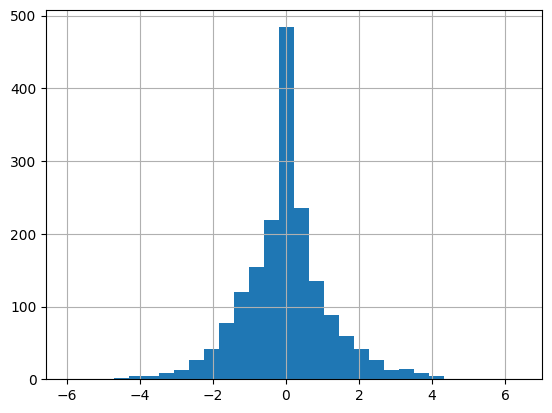

In [14]:
df_predictions.error.hist(bins=30)

In [15]:
#save model into a pickle file
with open("models/model_dt_Regression.pkl", 'wb') as f:
    pickle.dump(model_dt, f)

In [16]:
#Load pickle model
with open("models/model_dt_Regression.pkl", 'rb') as f:
    model_dt = pickle.load(f)

In [17]:
class RegressionModel(Strategy):
    limit_buy = 1
    limit_sell = -5
    
    def init(self):
        self.model = model_dt
        self.already_bought = False

    def next(self):
        explanatory_today = self.data.df.iloc[[-1], :]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        if forecast_tomorrow > self.limit_buy and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow < self.limit_sell and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass 

In [18]:
df_explanatory = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
df_explanatory

,Open,High,Low,Close,Volume
0,61.299999,61.580002,60.840000,61.009998,21220800
1,61.180000,61.990002,61.130001,61.970001,27349400
2,61.820000,62.299999,61.720001,62.169998,20198100
3,62.500000,63.419998,62.240002,62.980000,35718900
4,63.000000,63.450001,62.529999,62.680000,30352700
...,...,...,...,...,...
1784,385.489990,388.679993,384.649994,388.470001,21645700
1785,393.660004,394.029999,387.619995,390.269989,27202300
1786,387.980011,390.109985,384.809998,389.470001,22234100
1787,391.720001,393.989990,390.119995,393.869995,23392100


In [19]:
bt = Backtest(df_explanatory, RegressionModel,
              cash=10000, commission=0.002, exclusive_orders=True)

/var/folders/ys/s_50lzbs7rs9jt85q2gs20xc0000gn/T/ipykernel_822/969247589.py:1: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df_explanatory, RegressionModel,


In [20]:
results = bt.run()

In [21]:
results.to_frame(name='Values').loc[:'Return [%]']

,Values
Start,0.0
End,1788.0
Duration,1788.0
Exposure Time [%],97.875908
Equity Final [$],76531.16321
Equity Peak [$],76531.16321
Return [%],665.311632


In [22]:
#Optimize
#Create list for limit buy and sell
list_limits_buy = list(range(0, 11, 1))
list_limits_sell = list(range(-1, -11, -1))

result = bt.optimize(limit_buy = list_limits_buy,
           limit_sell = list_limits_sell,
           maximize = 'Return [%]',
           return_heatmap=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


In [23]:
result[0]

Start                                     0.0
End                                    1788.0
Duration                               1788.0
Exposure Time [%]                   99.888206
Equity Final [$]               2165482.974834
Equity Peak [$]                2165482.974834
Return [%]                       21554.829748
Buy & Hold Return [%]              553.450294
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -16.828563
Avg. Drawdown [%]                   -2.359585
Max. Drawdown Duration                   76.0
Avg. Drawdown Duration               7.099057
# Trades                                221.0
Win Rate [%]                        73.755656
Best Trade [%]                      33.309739
Worst Trade [%]                     -9.791965
Avg. Trade [%]                    

In [24]:
result[1]

limit_buy  limit_sell
0          -1            21554.829748
           -2             6672.141926
           -3             4479.750286
           -4             1859.696474
           -5              953.642483
                             ...     
10         -6             -100.000000
           -7             -100.000000
           -8             -100.000000
           -9             -100.000000
           -10            -100.000000
Name: Return [%], Length: 110, dtype: float64

In [25]:
dff = result[1].reset_index()

In [26]:
#Create a heatmap
dff = dff.pivot(index='limit_buy', columns='limit_sell', values='Return [%]')

In [27]:
dff.sort_index(axis=1, ascending=False)\
.style.format(precision=0)

limit_sell,-1,-2,-3,-4,-5,-6,-7,-8,-9,-10
limit_buy,,,,,,,,,,
0,21555,6672,4480,1860,954,692,558,538,514,514
1,2501,2653,1955,1171,665,690,591,570,498,498
2,162,1239,1108,882,455,467,419,403,348,348
3,-64,-2,50,150,158,151,268,317,336,336
4,-75,-0,68,193,194,140,253,301,317,317
5,-79,-6,18,170,222,166,253,301,317,317
6,-100,-100,-100,151,207,166,253,301,317,317
7,-100,-100,-100,-100,69,150,155,155,166,166
8,-100,-100,-100,-100,-100,-59,-57,-57,151,151


In [28]:
#optimize backtesting with multiple combinations
!pip install scikit-optimize
import multiprocessing as mp
#mp.set_start_method('fork')

In [29]:
stats_skopt, heatmap, optimize_result = bt.optimize(
    limit_buy=[0, 10],
    limit_sell=[-10, 0],
    maximize='Return [%]',
    method='skopt',
    max_tries=500,
    random_state=0,
    return_heatmap=True,
    return_optimization=True
)

Backtest.optimize:   5%|█▏                     | 27/500 [00:43<12:58,  1.65s/it]

In [30]:
dff = heatmap.reset_index()
dff = dff.pivot(index='limit_buy', columns='limit_sell', values='Return [%]')
dff

limit_sell,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
limit_buy,,,,,,,,,,,
0,NaN,513.668849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,590.521563,NaN,665.311632,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,466.791107,NaN,882.480665,NaN,1239.073707,NaN,3.627282
3,NaN,NaN,317.304059,NaN,NaN,NaN,NaN,49.668674,NaN,-64.483830,NaN
4,316.914514,NaN,NaN,NaN,NaN,NaN,NaN,67.947905,-0.377282,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,221.974695,NaN,NaN,NaN,-79.281124,-82.067135
6,NaN,316.914514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,165.761357,NaN,154.631945,NaN,NaN,NaN,NaN,NaN,NaN,-100.000000
8,NaN,NaN,NaN,NaN,-59.403856,-100.000000,NaN,-100.000000,NaN,NaN,NaN
